# Discretisation
- The process of binning/Transforming `continuous` variables into  `discrete` variables by creating a set of continuous intervals/bin that span range of value
- Discretisation can handle the `outlier` because each outlier may be in the lowest or highest bin.

**1. Why need to use Discretisation ?**
- **Reducing complexity**: Discretization can simplify the feature space by reducing the number of possible values that a feature can take on. This can make it easier to build models and `reduce the risk of overfitting`.
- **Meeting model assumptions**: Some models, such as `decision trees` and `naive Bayes classifiers`, are designed to work with categorical variables. Discretizing continuous variables can help these models perform better.
- **Dealing with sparsity**: In some datasets, certain values of a continuous variable may be rare or non-existent. Discretization can help address this issue by grouping together similar values and reducing the sparsity of the data.
- **Interpretability**: Discretization can make it easier to interpret the relationship between a feature and the target variable. For example, if we discretize age into categories like "young", "middle-aged", and "old", we can more easily see how age affects the outcome variable.

It's worth noting that discretization is not always necessary or appropriate. In some cases, it may be better to keep continuous variables as they are or to use other techniques, such as binning or scaling, to transform them. The choice of whether to discretize or not depends on the specific problem and the characteristics of the data.

**2. Approaches**
- ***Unsupervised***
    - Equal-width
    - Equal-frequency
    - K-means
- ***Supervised*** (need to inform the `target` variables)
    - Decision Trees
- ***Others***
    - Domain Knowledge

**Plus Encoding:** If using linear model and bins may not hold a linear relationship with target, encoding the variable after discretisation may help improve model performance to treat the bins as categories and to one hot encoding, or target guided encodings like mean encoding, weight of evidence, or target guided ordinal encoding. 

In [148]:
import plotly.graph_objects as go
def bin_hist(listvar, train, test = None, cols = 3):
    listvar = [listvar] if type(listvar)==str else listvar
    cols = min(cols, len(listvar))
    rows = (len(listvar) // cols) + 1 if ((len(listvar) % cols) != 0) else (len(listvar) // cols)
    fig = make_subplots(rows = rows, cols = cols , subplot_titles=listvar)
    for i, var in enumerate(listvar):     
        fig.add_trace(go.Histogram( x = train[var], name="train", marker_color='#656FF4', bingroup=i, histnorm = 'percent')#, texttemplate="%{y}")
                      , row=i//cols + 1, col=i%cols + 1 )
        if test is not None:
            fig.add_trace(go.Histogram( x = test[var], name="test", marker_color='#F85341', bingroup=i, histnorm = 'percent')#, texttemplate="%{y}")
                          , row=i//cols + 1, col=i%cols + 1 )
        
    fig.update_layout(autosize = True,height=rows*400, barmode='group', bargap=0.2, bargroupgap=0.05, showlegend=False, yaxis_title="percentage")
    fig.update_xaxes(categoryorder='category ascending')
    return fig#.show(renderer="jpeg")

In [132]:
data = pd.read_csv('Datasets/titanic.csv',usecols = ['age', 'fare', 'survived']).dropna()

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((731, 2), (314, 2))

## Equal-width
Equal width discretisation divides the scope of possible values into N bins of the same width.The width is determined by the range of values in the variable and the number of bins we wish to use to divide the variable:

`width` = (`max value` - `min value`) / `N`

where `N` is the number of bins or intervals, that is something to determine experimentally.

- Does not improve value spread
- Handles outliers
- Creates discrete variable
- Good to combine with categorical encodings

,age,fare,Age_disc_labels,Age_disc
943,37.0,9.5875,Bin_4,"(30.0, 40.0]"
195,16.0,86.5000,Bin_2,"(10.0, 20.0]"
1257,9.0,15.2458,Bin_1,"(-0.001, 10.0]"
1266,36.0,24.1500,Bin_4,"(30.0, 40.0]"
440,48.0,65.0000,Bin_5,"(40.0, 50.0]"
1113,26.0,13.7750,Bin_3,"(20.0, 30.0]"
1091,20.0,8.6625,Bin_2,"(10.0, 20.0]"
907,20.0,9.8250,Bin_2,"(10.0, 20.0]"
42,59.0,51.4792,Bin_6,"(50.0, 60.0]"
1131,32.0,8.0500,Bin_4,"(30.0, 40.0]"


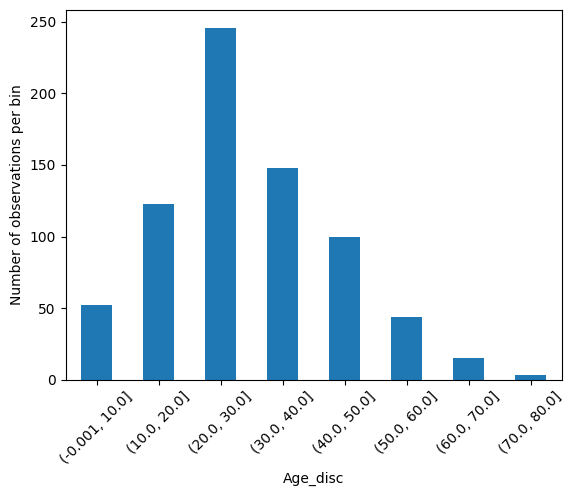

In [136]:
# pandas cut (cut by specific interval)
import matplotlib.pyplot as plt
X_train_copy = X_train.copy()

def gen_intervals(sr, N):
    # now let's capture the lower and upper boundaries
    min_value = int(np.floor( sr.min()))
    max_value = int(np.ceil( sr.max()))

    # let's round the bin width
    inter_value = int(np.round((max_value - min_value) / N))

    # interval list
    intervals = [i for i in range(min_value, max_value+inter_value, inter_value)]
    labels = ['Bin_' + str(i) for i in range(1, len(intervals))]
    return intervals, labels

intervals, labels = gen_intervals(X_train_copy['age'], N = 8)
X_train_copy['Age_disc_labels'] = pd.cut(x=X_train_copy['age'],bins=intervals, labels=labels, include_lowest=True)
X_train_copy['Age_disc'] = pd.cut(x=X_train_copy['age'], bins=intervals, include_lowest=True)

# plot
X_train_copy.groupby('Age_disc')['age'].count().plot.bar()
plt.xticks(rotation=45)
plt.ylabel('Number of observations per bin')

X_train_copy.head(10)

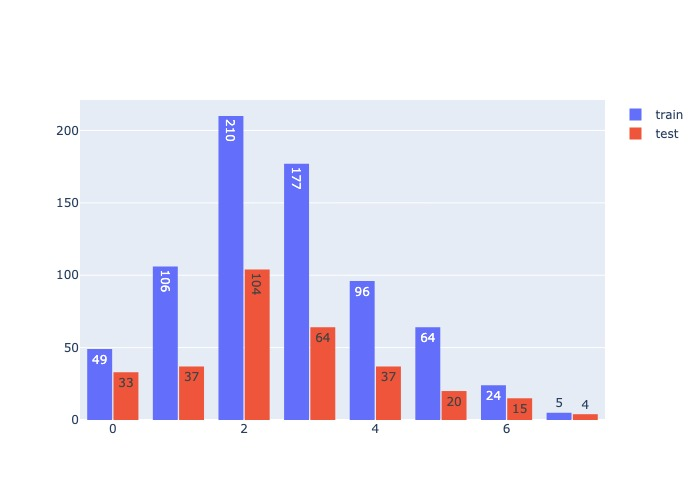

In [140]:
# sklearn
from sklearn.preprocessing import KBinsDiscretizer

disc = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform').set_output(transform="pandas")
disc.fit(X_train)

train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

bin_hist('age', train_t, test_t )

## Equal-frequency
- Equal frequency discretisation divides the scope of possible values of the variable into N bins, where each bin carries the same amount of observations.
- This is particularly useful for skewed variables as it spreads the observations over the different bins equally. We find the interval boundaries by determining the quantiles.
- Does not improve value spread
- Handles outliers
- Creates discrete variable
- Good to combine with categorical encodings

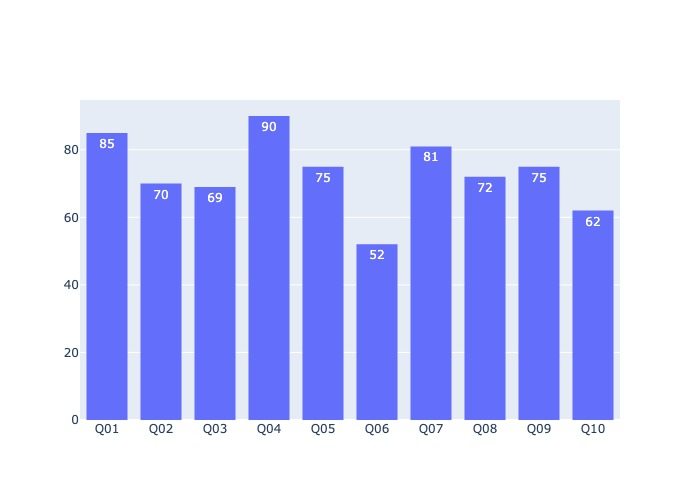

In [152]:
# pandas qcut (cut by Quantile base)
N = 10
labels = ['Q{:02.0f}'.format(i) for i in range(1, N+1)]
Age_disccretised, intervals = pd.qcut( X_train['age'], N, labels = labels,
                                      retbins=True, # return bin to use for pd.cut testset
                                      precision=3, duplicates='raise')
X_train_copy = X_train.copy()
X_train_copy['Age_disccretised_bin'] = Age_disccretised
bin_hist('Age_disccretised_bin', X_train_copy )

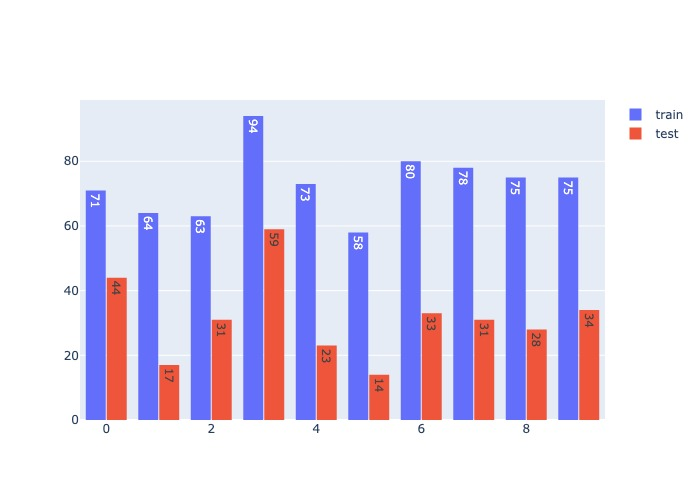

In [153]:
# sklearn 
disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile').set_output(transform="pandas")
disc.fit(X_train)

train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

bin_hist('age', train_t, test_t )

## K-mean
- With K number of clusters was be defined, the method consists in applying k-mean clustering to the continuous variable.
- **Unless you have reasons to believe that the values of the variable are organised in clusters, then use equal width discretisation as an alternative to this method**

In [154]:
disc = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')

## Decision Tree discretesation
- Discretisation with Decision Trees consists in using a decision tree to identify the **optimal bins**. 
- The `optimal bins` are the limitation outputs from tree model of limited `depth` (2, 3 or 4) using the `variable` and `target`

**1. Advantages**
- The `output` returned by the decision tree is *monotonically related* to the `target`.
- The tree end nodes, or bins in the discretised variable show decreased entropy: that is, **the observations within each bin are more similar among themselves than to those of other bins.**

**2. Limitations**
- Prone over-fitting
- More importantly, some tuning of the tree parameters needed to obtain the optimal number of splits (e.g., tree depth, minimum number of samples in one partition, maximum number of partitions, and a minimum information gain). This it can be time consuming.

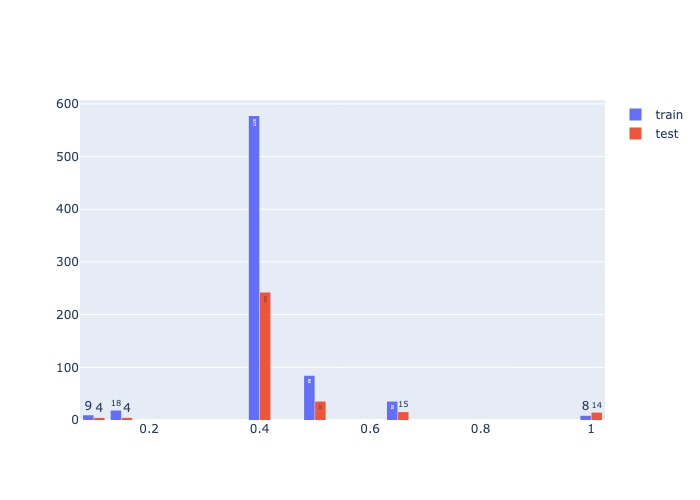

In [169]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

X_train_copy = X_train[['age']].copy()
X_test_copy = X_test[['age']].copy()

tree_model = DecisionTreeClassifier(max_depth=3)
tree_model.fit(X_train_copy, y_train)

train_t = pd.DataFrame(tree_model.predict_proba(X_train_copy)[:,1], columns = ['age'], index = y_train.index) # probability for class 1
test_t = pd.DataFrame(tree_model.predict_proba(X_test_copy)[:,1], columns = ['age'], index = y_test.index) # probability for class 1

bin_hist('age', train_t, test_t )

<AxesSubplot: title={'center': 'Monotonic age - target (test)'}, xlabel='age', ylabel='mean target'>

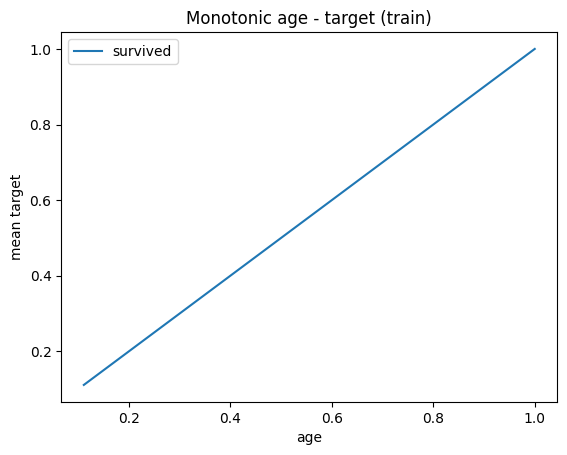

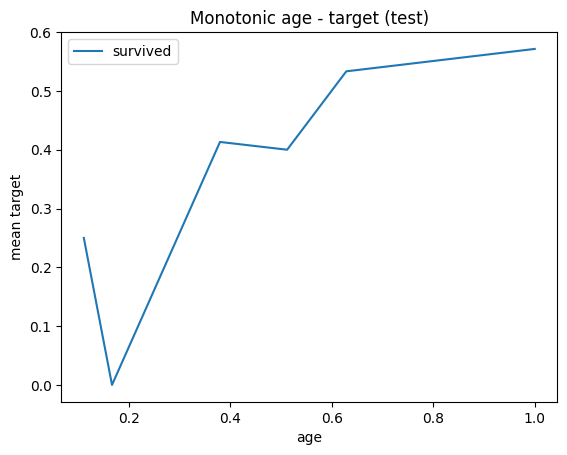

In [173]:
# check monotonic in train and test
y_train.to_frame().groupby(train_t['age']).mean().plot(title = 'Monotonic age - target (train)', ylabel = 'mean target')
y_test.to_frame().groupby(test_t['age']).mean().plot(title = 'Monotonic age - target (test)', ylabel = 'mean target')
# test is not monotonic ==> overfiting

In [175]:
# optimize the tree model
# choose the depth that generates the best roc-auc

from sklearn.model_selection import cross_val_score
score_ls = []  # here we store the roc auc
score_std_ls = []  # here we store the standard deviation of the roc_auc

for tree_depth in [1, 2, 3, 4]:

    # call the model
    tree_model = DecisionTreeClassifier(max_depth=tree_depth)

    # train the model using 3 fold cross validation
    scores = cross_val_score(tree_model, X_train_copy, y_train, cv=3, scoring='roc_auc')
    
    # save the parameters
    score_ls.append(np.mean(scores))
    score_std_ls.append(np.std(scores))

    
# capture the parameters in a dataframe
temp = pd.concat([pd.Series([1, 2, 3, 4]), pd.Series(
    score_ls), pd.Series(score_std_ls)], axis=1)

temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
temp

,depth,roc_auc_mean,roc_auc_std
0,1,0.532756,0.009545
1,2,0.519149,0.015073
2,3,0.514044,0.007280
3,4,0.519165,0.012087


## Domain knowledge discretisation
Frequently, when engineering variables in a business setting, the business experts determine the intervals in which they think the variable should be divided so that it makes sense for the business

In [180]:
# feature_engine
from feature_engine.discretisation import ArbitraryDiscretiser

dis = ArbitraryDiscretiser({'age':[0,20,40,60,200]})
dis.fit(X_train)
dis.transform(X_train)

,age,fare
943,1,9.5875
195,0,86.5000
1257,0,15.2458
1266,1,24.1500
440,2,65.0000
...,...,...
1290,2,7.0000
846,0,9.5000
952,1,7.7750
614,1,7.8875


In [176]:
# pandas
pd.cut(X_train['age'], bins=[0,20,40,60,200], include_lowest=True)

943       (20.0, 40.0]
195     (-0.001, 20.0]
1257    (-0.001, 20.0]
1266      (20.0, 40.0]
440       (40.0, 60.0]
             ...      
1290      (40.0, 60.0]
846     (-0.001, 20.0]
952       (20.0, 40.0]
614       (20.0, 40.0]
745       (20.0, 40.0]
Name: age, Length: 731, dtype: category
Categories (4, interval[float64, right]): [(-0.001, 20.0] < (20.0, 40.0] < (40.0, 60.0] < (60.0, 200.0]]